**Antoni Kois**

## Polecenie
W ramach projektu zaliczeniowego na podstawie danych dziennych przebiegających przez min. 8 lat (np. 2018-2025) należy:

- opisać empiryczny rozkład stóp zwrotu (wyświetlić statystyki opisowe oraz skomentować kluczowe wyniki).
- za pomocą min. dwóch testów normalności sprawdzić, czy dane dzienne spełniają założenie o normalności.
- dwoma wybranymi wersjami metody historycznej (prosta metoda historyczna, metoda historyczna z wagami, metoda uwzględniająca heteroskedastyczność poprzez EWMA lub model GARCH(1,1), metoda Monte Carlo)  w oparciu o 500-dniowe okno historyczne, zbudować szereg oszacowań 99% VaR i 99% ES.
- w oparciu o wyniki testów wstecznych (dla długości m = 250) odpowiedzieć na pytanie, czy wyznaczony VaR jest wyznaczony wiarygodnie (tj. nie jest zawyżony ani zaniżony). Czy owe wyniki pozwalają twierdzić, że obie metody dają wiarygodne oszacowania?
Uwaga: Każda praca będzie podlegała osobistej obronie (na żywo). W jej ramach będę weryfikował rozumienie kluczowych pojęć (definicja VaR i ES, rozumienie wybranych technik liczenia VaR i ES, rozumienie istoty testów wstecznych), a także sprawdzał samodzielność wykonanej pracy.

Praca zaliczeniowa ani jej recenzja NIE MOŻE  być wygenerowana przez sztuczną inteligencję (np. poprzez wygenerowanie tekstu interpretacji czy wygenerowanie znaczącej części kodu). W przypadku stwierdzenia takiego faktu podczas obrony, niezależnie od wyników uzyskanych w ramach projektu, wystawię ocenę 2.0.

## Wstęp

Do przeprowadzenia projektu użyję danych dotyczących cen Bitcona.
Wybrałem to aktywo głownie z trzech powodów
- pracuję na codzień w branży kryptowalut
- jest to coś innego i świeżego (inne zachowanie niż stabilne aktywa)
- tworzę modele do algorytmicznego handlowania m.in na Bitcoinie, dlatego zawsze może to być jakaś część dodana do moich modeli

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats

## Ładownaie danych

Ładuję dane z pliku csv. Są to dzienne zwroty Bitcoina w stosunku do dolara amerykańskiego na przestrzeni lat.

In [2]:
CSV_PATH = Path('../data/btcusd_d.csv')

data_btcusdt_frame_daily: pd.DataFrame = pd.read_csv(
        CSV_PATH,
        usecols=['datetime', 'open', 'high', 'low', 'close'],
        parse_dates=['datetime']
    )
# Ustawiam odpowiednio indeks
data_btcusdt_frame_daily.set_index('datetime').sort_index().astype('float64')  

# konwersja kolumny 'Data' na datetime, bo bez tego są błedne daty
data_btcusdt_frame_daily['datetime'] = pd.to_datetime(data_btcusdt_frame_daily['datetime'], errors='coerce')

# usuwam ewentualne błędne wiersze bez dat
data_btcusdt_frame_daily = data_btcusdt_frame_daily.dropna(subset=['datetime'])

# indeks i sortuje
data_btcusdt_frame_daily = (
    data_btcusdt_frame_daily
    .set_index('datetime')
    .sort_index()
    .astype('float64')
)

print(data_btcusdt_frame_daily.head(10))

               open     high      low    close
datetime                                      
2010-07-17  0.04951  0.04951  0.04951  0.04951
2010-07-18  0.08584  0.08584  0.08584  0.08584
2010-07-19  0.08080  0.08080  0.08080  0.08080
2010-07-20  0.07474  0.07474  0.07474  0.07474
2010-07-21  0.07921  0.07921  0.07921  0.07921
2010-07-22  0.05050  0.05050  0.05050  0.05050
2010-07-23  0.06262  0.06262  0.06262  0.06262
2010-07-24  0.05454  0.05454  0.05454  0.05454
2010-07-25  0.05050  0.05050  0.05050  0.05050
2010-07-26  0.05600  0.05600  0.05600  0.05600


## Wykres Bitcoina

Na wstępie narysukę wykres ceny Bitcoina, by sprawdzić czy dane wyglądają poprawnie i czy nie ma jakiegoś problemu z nimi.

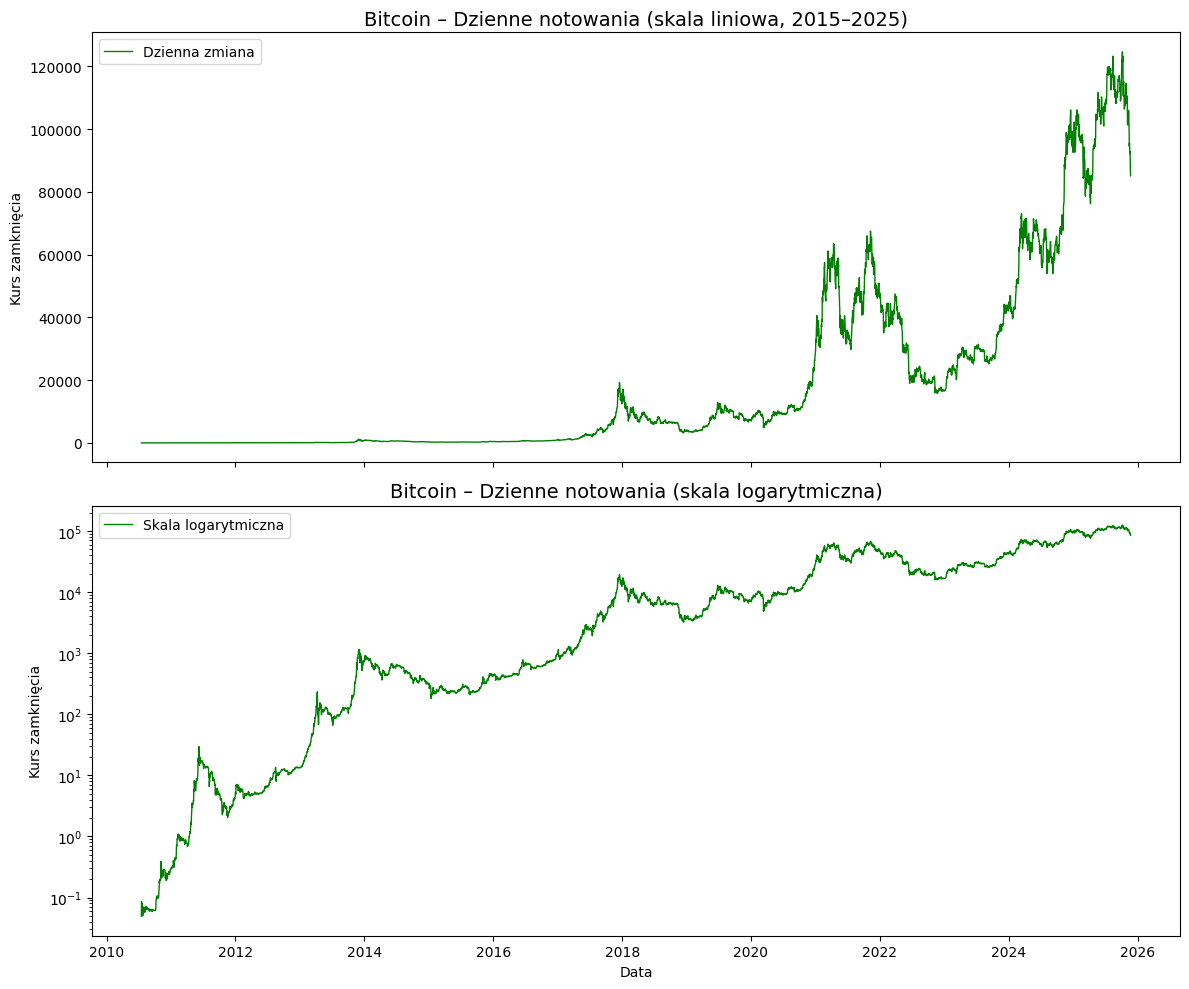

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

axes[0].plot(
    data_btcusdt_frame_daily.index,
    data_btcusdt_frame_daily['close'],
    label='Dzienna zmiana',
    color='green',
    linewidth=1
)
axes[0].set_title('Bitcoin – Dzienne notowania (skala liniowa, 2015–2025)', fontsize=14)
axes[0].set_ylabel('Kurs zamknięcia')
axes[0].legend()

axes[1].plot(
    data_btcusdt_frame_daily.index,
    data_btcusdt_frame_daily['close'],
    label='Skala logarytmiczna',
    color='green',
    linewidth=1
)
axes[1].set_title('Bitcoin – Dzienne notowania (skala logarytmiczna)', fontsize=14)
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Kurs zamknięcia')
axes[1].set_yscale('log')
axes[1].legend()

plt.tight_layout()
plt.show()

**Dane wyglądają poprawnie**. Dodałem także wykres w skali logarytmicznej, by lepiej podejrzeć jak wyglądała zmienność Bitcoina w jego wczesnych latach.
Jak możemy zauważyć, początkowo zmienność była bardzo spora, a z czasem zaczyna ona maleć.
Nie jest to żadnym zaskoczeniem, tak często zachowują się młode aktywa, które dopiero z czasem i adopcją nabierają stabilności.

Z racji iż projekt ma zawierać zakres 2018-2025, przytnę teraz dane, jednak **chciałbym zostawić ich trochę więcej, by móc zobaczyć jak zmieniał się VaR na przestrzeni czasu wraz ze stabilizującymi się notowaniami Bitcoina**.
Dlatego **mój zakres badania będzie od 2015 roku do 2025 roku** (do daty do której pobrałem dane w tamtym momencie, czyli 21 listopada 2025).
Mam nadzieję, że wyłamanie się z zakresu i wydłużenie zakresu badania nie wpływnie negatywnie na ocenę.

In [4]:
START_DATE = "2015-01-01"
data_btcusdt_frame_daily_2015 = data_btcusdt_frame_daily.loc[START_DATE:].copy()

# Sprawdzam czy są braki w danych dziennych
start_date = data_btcusdt_frame_daily_2015.index.min()
end_date = data_btcusdt_frame_daily_2015.index.max()
expected_obs = (end_date - start_date).days + 1
actual_obs = len(data_btcusdt_frame_daily_2015)
missing_obs = expected_obs - actual_obs

print(
    f"Zakres dat po przycięciu: {start_date.date()}; {end_date.date()} "
    f"(liczba obserwacji: {actual_obs})"
)

print(f"Teoretycznie dziennych obserwacji powinno być: {expected_obs}. ")
if missing_obs > 0:
    print(f"Brakuje: {missing_obs} dni.")
else:
    print("Wszystkie dane są poprawne, nie brakuje żadnych dziennych zwrotów.")

print(data_btcusdt_frame_daily_2015.head())

Zakres dat po przycięciu: 2015-01-01; 2025-11-21 (liczba obserwacji: 3978)
Teoretycznie dziennych obserwacji powinno być: 3978. 
Wszystkie dane są poprawne, nie brakuje żadnych dziennych zwrotów.
              open        high     low   close
datetime                                      
2015-01-01  322.31  324.997030  313.81  314.96
2015-01-02  314.54  319.999990  313.28  315.81
2015-01-03  315.80  315.990000  277.50  279.30
2015-01-04  279.30  288.740000  255.03  264.19
2015-01-05  264.04  280.410588  263.75  274.84


## Stopy zwrotu Bitcoina

Teraz tworzę funkcje pomocnicze, które pozwolą mi na łatwe wyznaczanie stóp zwrotu (prostą i logarytmiczną)
Wykorzystuję do tego funkcje pomocnicze z poprzednich ćwiczeń z tą różnicą, iż zamiast zwracać zwroty w procentach, będę je zwracac w ułamkach.
W dalszej części projektu skupię się na analizie **stóp logarytmicznych**.

In [5]:
def compute_returns(series: pd.Series) -> pd.DataFrame:
    returns = pd.DataFrame(index=series.index)
    returns["simple_frac"] = (series - series.shift(1)) / series.shift(1)
    returns["log_frac"] = np.log(series / series.shift(1))
    return returns

def plot_returns(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df["simple_frac"], label="Stopa prosta")
    ax.plot(df.index, df["log_frac"], label="Stopa logarytmiczna")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Data")
    ax.set_ylabel("Stopa zwrotu (%)")
    ax.legend()

    plt.tight_layout()
    plt.show()

            simple_frac  log_frac
datetime                         
2025-11-12    -0.013629 -0.013723
2025-11-13    -0.019304 -0.019493
2025-11-14    -0.051138 -0.052492
2025-11-15     0.010595  0.010539
2025-11-16    -0.013963 -0.014061
2025-11-17    -0.021709 -0.021948
2025-11-18     0.008086  0.008054
2025-11-19    -0.015123 -0.015239
2025-11-20    -0.053713 -0.055210
2025-11-21    -0.017404 -0.017557


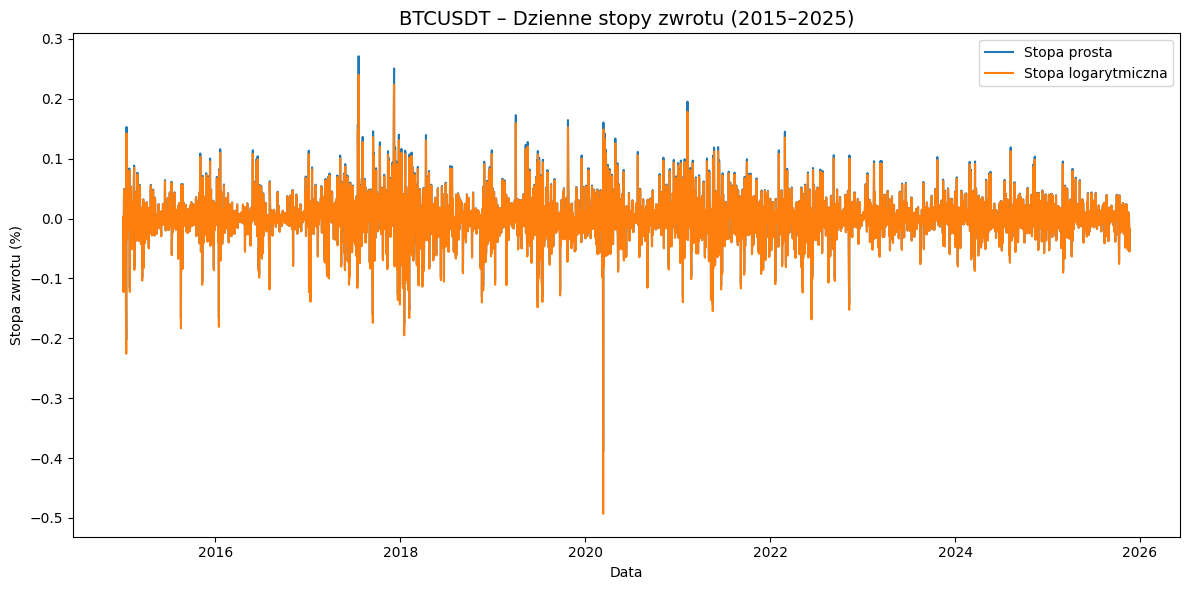

In [6]:
returns_daily = compute_returns(data_btcusdt_frame_daily_2015["close"])
returns_daily = returns_daily.dropna()
returns_daily_log = returns_daily["log_frac"]
returns_daily_pct = returns_daily[["simple_frac", "log_frac"]] * 100
returns_daily_log_pct = returns_daily_log * 100

print(returns_daily.tail(10))
plot_returns(returns_daily, "BTCUSDT – Dzienne stopy zwrotu (2015–2025)")

Jak możemy zauważyć po wykresie zwrotów, **Bitcoin charakteryzuje się bardzo mocnymi wahaniami wyceny**. Co **jest jednocześnie jego plusem i minusem** w zależności jakeigo typu inwestorem jesteśmy.
Można też bardzo szybko zauważyć **crash covidowy**, który spowodował mocne spadki na giełdach. Nie omineło to także Bitcoina, gdzie możemy zauważyć **~50% spadek według stopy logarytmicznej**.

In [7]:
# Statystyki opisowe dziennych stóp zwrotu (w %)
stats_desc = returns_daily_pct.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
tail_desc = returns_daily_pct.agg(['skew', 'kurtosis']).T

print("Statystyki opisowe dziennych stóp zwrotu (w %):")
print(stats_desc.to_string(float_format=lambda x: f"{x:0.4f}"))

print("\nSkośność i kurtoza:")
print(tail_desc.to_string(float_format=lambda x: f"{x:0.2f}"))

Statystyki opisowe dziennych stóp zwrotu (w %):
                count   mean    std      min       1%      5%    50%    95%     99%     max
simple_frac 3977.0000 0.2061 3.5967 -38.9320 -10.4621 -5.5213 0.1301 5.7446 10.6091 27.1104
log_frac    3977.0000 0.1408 3.6239 -49.3182 -11.0508 -5.6796 0.1300 5.5856 10.0832 23.9886

Skośność i kurtoza:
             skew  kurtosis
simple_frac -0.13      7.92
log_frac    -0.78     12.70


Od razu po opisie rozkładu możemy zauważyć, iż istnieje spora różnica między największym zyskiem a największą stratą. Jest to różnica około dwukrotna.
Na wstępie wytłumaczenie mogłoby być takie, że statystykę zniekształca nam "covidowy crash".
Jednak jeśli sprawdzimy percentyle 1% i 99%, a nie tylko ekstrema, zauważymy, iż ten efekt nadal się utrzymuje.

* 1%: `-11.0508`
* 99%: `10.0832`

Jest to różnica około 1 punktu procentowego, co na rynkach finansowych jest wartością dość znaczną.
Przeanalizujemy jeszcze skośność i kurtozę, by potwierdzić, iż częściej występują ekstremalne spadki niż zyski.

Jednak też już teraz mogę założyć, iż ta analiza potwierdzi powyższą tezę. Wynika to z faktu, iż rynki często charakteryzują się tym, że inwestorzy częściej ekstremalnie panikują, powodując jeszcze mocniejsze spadki (boją się większych strat niż te, co mają, dlatego sprzedają), niż reagują na ekstremalne wzrosty. Tutaj działa po prostu ludzka psychika.

**Skośność:**
`-0.78`
Jest wyraźnie ujemna, co oznacza, że "ogon" wykresu po lewej stronie (straty) jest dłuższy i "grubszy" niż po prawej (zyski). Mimo że Bitcoin kojarzy się z wielkimi wzrostami, statystyka ta mówi, że ekstremalne spadki są bardziej prawdopodobne (lub silniejsze) niż ekstremalne wzrosty o tej samej skali.
Sugerowało by to tendencję do występowania tzw. "crashów", czyli nagłych, głębokich załamań cenowych.

**Kurtoza:**
`12.70`
Dla rozkładu normalnego kurtoza wynosi 3 (dla wygody odejmuje się tę wartość i tworzy tzw. "współczynnik ekscesu").
Nasz wynik w porównaniu do tej trójki jest ogromny. Taki wynik oznacza, iż nasz rozkład jest leptokurtyczny (kurtoza > 0), co mówi, że intensywność wartości skrajnych jest większa niż dla rozkładu normalnego.

Obie miary kurtoza i skośność potwierdzają nam, że na rynku Bitcoina często występują skrajne zwroty.

## Histogram stóp zwrotów

In [8]:
# Histogram rozkładu dziennych stóp zwrotu logarytmicznych (w %)
quantiles = returns_daily_log_pct.quantile([0.01, 0.05, 0.5, 0.95, 0.99])

fig_int = px.histogram(
    returns_daily_log_pct,
    nbins=100,
    histnorm="probability density",
    title="Interaktywny histogram stóp zwrotu logarytmicznych (w %)",
    labels={"value": "Dzienna stopa zwrotu (%)"},
)
fig_int.add_vline(x=quantiles.loc[0.01], line_dash="dash", line_color="crimson", annotation_text="1%")
fig_int.add_vline(x=quantiles.loc[0.05], line_dash="dash", line_color="orange", annotation_text="5%")
fig_int.add_vline(x=quantiles.loc[0.95], line_dash="dash", line_color="royalblue", annotation_text="95%")
fig_int.add_vline(x=quantiles.loc[0.99], line_dash="dash", line_color="navy", annotation_text="99%")
fig_int.update_layout(bargap=0.02, showlegend=False)
fig_int.show()

Na histogramie widzimy, iż jednak **covidowy spadek jest sporym outlinerem**. Dlatego **dla testu usunę go i jeszcze raz spradzę skośność i kurtozę** czy faktycznie sprzyja częstszym drasrycznym spadkom, czy jednak to było tylko przez tego jednego outlinera.

## Histogram stóp zwrotów bez outlinera (Covidowego Crasha)

In [9]:
# Statystyki zwrotów bez największego ujemnego zwrotu z 2020 r. (w %)
covid_min_idx = returns_daily_log_pct.loc['2020'].idxmin()
returns_pct_no_outliers = returns_daily_pct.drop(index=covid_min_idx)

stats_desc_no = returns_pct_no_outliers.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
tail_desc_no = returns_pct_no_outliers.agg(['skew', 'kurtosis']).T

print(f'Liczba obserwacji po filtracji: {len(returns_pct_no_outliers)} ({len(returns_daily_pct)} wcześniej)')
print('Statystyki opisowe (w %):')
print(stats_desc_no.to_string(float_format=lambda x: f"{x:0.4f}"))

print('Skośność i kurtoza (w %):')
print(tail_desc_no.to_string(float_format=lambda x: f"{x:0.2f}"))

Liczba obserwacji po filtracji: 3976 (3977 wcześniej)
Statystyki opisowe (w %):
                count   mean    std      min       1%      5%    50%    95%     99%     max
simple_frac 3976.0000 0.2160 3.5432 -20.1999 -10.4024 -5.5029 0.1306 5.7448 10.6104 27.1104
log_frac    3976.0000 0.1532 3.5384 -22.5646 -10.9842 -5.6602 0.1305 5.5858 10.0844 23.9886
Skośność i kurtoza (w %):
             skew  kurtosis
simple_frac  0.19      4.85
log_frac    -0.16      4.66


Sam rozkład zwrotów percentyli jest niemal identyczny, czego można było się spodziewać, bo usuneliśmy tylko jedną obserwację.
Jednak widać, że wpłyneło to mocno na wartości skośnści i kurtozy.
			
**Skośność**
Przed: -0.78
Po: -0.07

**Kurtoza**
Przed: 12.70
Po: 1.51

Są to bardzo spore różnice, więc w dalszej analizie warto mieć to z tyłu głowy co może wpływać na być może jakieś nieprzewidziane i zaskakujące wyniki.

In [10]:
returns_pct_no_outliers_log = returns_pct_no_outliers['log_frac']
quantiles_no = returns_pct_no_outliers_log.quantile([0.01, 0.05, 0.95, 0.99])
fig_int = px.histogram(
    returns_pct_no_outliers_log,
    nbins=120,
    histnorm='probability density',
    title='Interaktywny histogram stóp zwrotu logarytmicznych (bez wartości odstających)',
    labels={'value': 'Dzienna stopa zwrotu (%)'},
)
fig_int.add_vline(x=quantiles_no.loc[0.01], line_dash='dash', line_color='crimson', annotation_text='1%')
fig_int.add_vline(x=quantiles_no.loc[0.05], line_dash='dash', line_color='orange', annotation_text='5%')
fig_int.add_vline(x=quantiles_no.loc[0.95], line_dash='dash', line_color='royalblue', annotation_text='95%')
fig_int.add_vline(x=quantiles_no.loc[0.99], line_dash='dash', line_color='navy', annotation_text='99%')
fig_int.update_layout(bargap=0.03, showlegend=False)
fig_int.show()


## Testy normalności rozkładu logarytmicznych stóp zwrotu

Teraz aby sprawdzić normalnosć wyników przeprowadzę 4 testy normalności, będą to
- Test Jarque-Bera (JB)
- Test Shapiro-Wilka
- Test Andersona-Darlinga
- Test Kołmogorowa-Smirnowa

In [11]:
def run_tests(series):
    mu, sigma = series.mean(), series.std(ddof=1)

    results = []

    # 1. JB
    jb_stat, jb_p = stats.jarque_bera(series)
    results.append(
        {
            "Test": "Jarque-Bera",
            "p-value": f"p={jb_p:}",
            "Czy normalny?": "NIE" if jb_p < 0.05 else "TAK",
        }
    )

    # 2. Shapiro-Wilk
    sw_stat, sw_p = stats.shapiro(series)
    results.append(
        {
            "Test": "Shapiro-Wilk",
            "p-value": f"p={sw_p:}",
            "Czy normalny?": "NIE" if sw_p < 0.05 else "TAK",
        }
    )

    # 3. Kołmogorow-Smirnow
    ks_stat, ks_p = stats.kstest(series, "norm", args=(mu, sigma))
    results.append(
        {
            "Test": "Kolmogorow-Smirnow",
            "p-value": f"p={ks_p:}",
            "Czy normalny?": "NIE" if ks_p < 0.05 else "TAK",
        }
    )

    # 4. Anderson-Darling (nie ma p-value wprost)
    ad = stats.anderson(series, dist="norm")
    # Dla poziomu istotności 5% indeks to 2 (w tablicy: 15%, 10%, 5%, 2.5%, 1%)
    ad_crit_5pct = ad.critical_values[2]
    ad_is_normal = ad.statistic < ad_crit_5pct
    results.append(
        {
            "Test": "Anderson-Darling",
            "p-value": f"Stat={ad.statistic:.2f} (Kryt={ad_crit_5pct:.2f})",
            "Czy normalny?": "TAK" if ad_is_normal else "NIE",
        }
    )

    df_res = pd.DataFrame(results)

    print(f"\nWyniki testów normalnosći logarytmicznych stóp zwrotu")
    print(df_res.to_string(index=False))

run_tests(returns_daily_log_pct)


Wyniki testów normalnosći logarytmicznych stóp zwrotu
              Test                  p-value Czy normalny?
       Jarque-Bera                    p=0.0           NIE
      Shapiro-Wilk  p=4.920491652000817e-44           NIE
Kolmogorow-Smirnow p=1.2620485025175827e-34           NIE
  Anderson-Darling   Stat=83.33 (Kryt=0.79)           NIE


Tak jak możemy wyczytać z wyników, **żaden test nie potwierdził normalności rozkładu stóp zwrotu**.
Było to do przewidzenia, gdyż aktywa przeważnie nie posiadają stóp zwrotu z rozkładem normalnym, a tmy bardziej można było się tego spodziewać bo świeżym aktywie.

Jarque-Bera daje wartość zera. Jest to wartość spodziewana po tym jak wygląda nasza skośność i kurtoza rozkładu.
Kolejnme dwa tetsy Shapiro-Wilk i Kolmogorow-Smirnow dają wartości niemal bliskie zeru.

Test Anderson-Darling także odrzuca tezę o normalności. Widzimy sporą różnicę między statystyką testu a wartością krytyczną dla poziomu istotności 5%. Moglismy się tego spodizewać bo już poprzednie testy wskazywały nam, że normlaności rozkładu jest definitywnie odrzucana.

Podsumowując, tesy pokazują, że **rozkład logarytmicznych zwrotów nie jest normalny**

## Wyzanczanie VaR i ES przy pomocy EWMA io GARCH(1,1)

Teraz zprzechodzimy do sekcji wyzanczania VaR i ES
Definiuję zmienne pomocnicze którę będę wykorzystywać przez resztę analizy

In [12]:
# Wspólne parametry oraz serie do dalszych obliczeń ryzyka
WINDOW = 500  # długość okna dla VaR/ES oraz inicjalizacji modeli
QUANTILE_LEVEL = 0.99  # poziom ufności VaR
QUANTILE_LEVEL_PERCENTAGE = QUANTILE_LEVEL * 100
LAMBDA = 0.94  # parametr wygładzania dla EWMA

returns_daily_log_values = returns_daily_log.values
returns_daily_log_pct_values = returns_daily_log_pct.values

# Straty = -log-stopy zwrotu
losses_daily_log = -returns_daily_log
losses_daily_log_pct = losses_daily_log * 100
losses_daily_log_values = losses_daily_log.values

# Wspólny indeks dat
dates = returns_daily_log.index

### EWMA (Exponentially Weighted Moving Average)

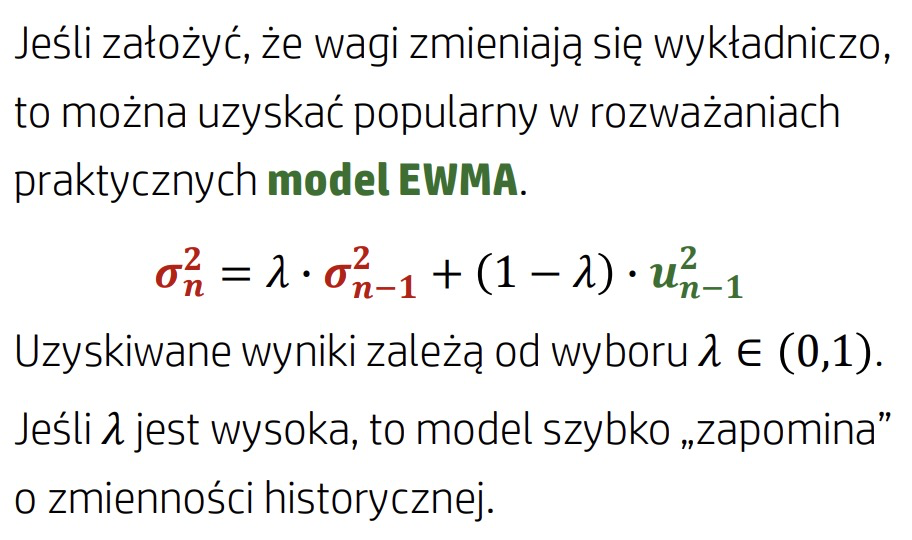

Gdzie:
- sigma_n^2 – bieżąca wariancja (prognoza zmienności).
- sigma_{n-1}^2 – poprzednia wariancja.
- u_{n-1} – ostatni log-zwrot
- lambda ∈ (0,1) – klasycznie to 0.94 i taką też wartość użyjemy na start.


Kod poniżej jest podzielony na dwa bloki.
Pierwszy oblicza dynamiczną wariancję "ręcznie", a na jej podstawie Value at Risk (VaR) oraz Expected Shortfall (ES) przy użyciu modelu EWMA. Model ten nadaje większą wagę nowszym obserwacjom, dzięki czemu szybciej reaguje na zmieniającą się zmienność rynkową.

In [13]:

# tablica na wyniki (same zera na start)
sigmas = np.zeros(len(losses_daily_log_values))

# inicjalizacja
# musimy od czegoś zacząć dlatego biorę wariancję z pierwszych 500 dni jako wartość startową
current_var = np.var(losses_daily_log_values[:WINDOW])

# pętla licząca EWMA tak jak wedgług wzoru
for i in range(len(losses_daily_log_values)):
    # Zapisujemy obecną sigmę (pierwiastek z wariancji)
    sigmas[i] = np.sqrt(current_var)
    
    # Aktualizujemy wariancję na kolejny dzień
    # var_new = lambda * var_old + (1-lambda) * zwrot^2
    current_var = LAMBDA * current_var + (1 - LAMBDA) * (losses_daily_log_values[i]**2)

sigma_ewma = pd.Series(sigmas, index=returns_daily_log.index, name="Sigma EWMA")

# Obliczenie EWMA z Pandas (Dla porównania, bo ma wbudowane)
# alpha = 1 - lambda.
# adjust=False sprawia, że liczy to wg wzoru rekurencyjnego (jak w pętli).
# używamy .shift(1) ponieważ nasza pętla zapisuje sigmas[i] przed aktualizacją o losses_daily_log_values[i].
sigma_ewma_pandas = (
    returns_daily_log.pow(2)
    .ewm(alpha=1-LAMBDA, adjust=False)
    .mean()
    .shift(1)
    .pow(0.5)
)
sigma_ewma_pandas.name = "Sigma Pandas"

# góra: Zmienność EWMA (Sigma)
# dół: Dzienne Zwroty
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Zmienność Dziennia EWMA (Sigma)", "Dzienne Stopy Zwrotu"),
    row_heights=[0.7, 0.3]
)

# Ręczna
fig.add_trace(go.Scatter(
    x=sigma_ewma.index,
    y=sigma_ewma * 100,
    mode='lines',
    name='Sigma EWMA (Ręczna)',
    line=dict(color='orange', width=2)
), row=1, col=1)

# Pandas (Weryfikacja)
fig.add_trace(go.Scatter(
    x=sigma_ewma_pandas.index,
    y=sigma_ewma_pandas * 100,
    mode='lines',
    name='Sigma EWMA (Pandas)',
    line=dict(color='blue', width=1.5, dash='dash')
), row=1, col=1)


# zwroty
fig.add_trace(go.Scatter(
    x=returns_daily_log.index,
    y=returns_daily_log * 100,
    mode='lines',
    name='Dzienne Zwroty',
    line=dict(color='gray', width=1),
    opacity=0.5
), row=2, col=1)

fig.update_layout(
    title=f"Model EWMA (lambda={LAMBDA}) – Zmienność vs Zwroty",
    template="plotly_white",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    height=700
)

fig.update_yaxes(title_text="Zmienność [%]", row=1, col=1)
fig.update_yaxes(title_text="Zwrot [%]", row=2, col=1)

fig.show()


Tak jak możemy zauważyć, **moje obliczenia są zgodne z obliczeniami gotowego rozwiązania** przez Pnadas.
Widać wyraźnie, że od **około roku 2018 zmienność Bitcoina zaczyna maleć wraz z czasem, poza tym jednym covidowym wybiciem**.
Jest to najwęŻsza zmienność zanotowana na zakresie naszego projektu.
Dla porównania, pod wykresem EWMA zamieściłem wykres zwrotów.

### VaR i ES przy pomocy EWMA (99%, okno 500)

Wiemy, że rozkład zwrotów nie jest normalny oraz, że nie są one stałe w czasie.
Występuje to zjawisko heteroskedastyczości, czyli widzimy po wykresie, że zmienność jest skupiona.

Dla obliczeń wykorzystamy wzory przedstawione na wykładzie, czyli:

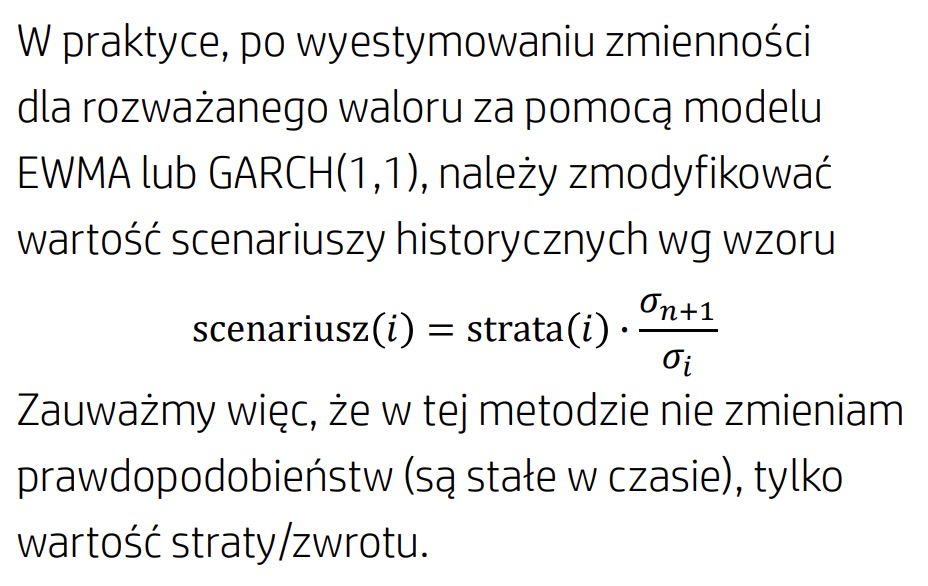

Tłumacząc podany wzór.

- Pobieramy WINDOW wartości wstecz (czyli nasze 500).
- Wykonujemy standaryzację i skalowanie.
- Pętla dla każdej z tych 500 par wykonujemy przeliczenie:
- Bierzemy historyczną stratę.
- Mnożysz ją przez stosunek: `zmienność_dzisiaj / zmienność_wtedy`.
- Otrzymujemy 500 nowych, hipotetycznych strat (scenariuszy) dopasowanych do dzisiejszego ryzyka.
- Teraz z tych hipotetycznych 500 scenariuszy możemy wyliczyć prostą metodą VaR i ES

In [14]:
sigma_ewma_values = sigma_ewma.values

# wyniki
ewma_var_results = []
ewma_es_results = []

# Zaczynamy od dnia WINDOW (czyli 500), bo potrzebujemy historii wstecz
for i in range(WINDOW, len(losses_daily_log_values)):
    
    # dzisiejsza zmienność (prognoza na ten dzień)
    # licznik ułamka: sigma_{n+1}
    current_sigma = sigma_ewma_values[i]
    
    # okno historyczne (ostatnie WINDOW dni)
    # window_losses - 'strata(i)'
    # window_sigmas - 'sigma(i)' (zmienność, która była wtedy)
    window_losses = losses_daily_log_values[i-WINDOW : i]
    window_sigmas = sigma_ewma_values[i-WINDOW : i]
    
    # Tworzymy WINDOW hipotetycznych scenariuszy (wzór orginalny)
    scaled_scenarios = window_losses * (current_sigma / window_sigmas)
    
    # Wyliczenie VaR (99-ty percentyl ze scenariuszy)
    var_val = np.quantile(scaled_scenarios, QUANTILE_LEVEL)
    
    # Wyliczenie ES (średnia ze scenariuszy gorszych niż VaR)
    es_val = scaled_scenarios[scaled_scenarios >= var_val].mean()
    
    ewma_var_results.append(var_val)
    ewma_es_results.append(es_val)

# Indeks musi zaczynać się od daty WINDOW, bo wcześniej nie mamy wyników
results_index = dates[WINDOW:]

ewma_var_series = pd.Series(ewma_var_results, index=results_index, name="VaR 99% (EWMA)")
ewma_es_series = pd.Series(ewma_es_results, index=results_index, name="ES 99% (EWMA)")

print("Ostatnie 5 wyników VaR:")
print(ewma_var_series.tail())


Ostatnie 5 wyników VaR:
datetime
2025-11-17    0.067907
2025-11-18    0.067640
2025-11-19    0.065826
2025-11-20    0.064723
2025-11-21    0.073892
Name: VaR 99% (EWMA), dtype: float64


In [15]:
fig = go.Figure()

# rzeczywiste straty (żeby widzieć skuteczność modelu)
fig.add_trace(go.Scatter(
    x=results_index,
    y=losses_daily_log_values[WINDOW:] * 100,
    mode='lines',
    name='Rzeczywista Strata (Log)',
    line=dict(color='silver', width=1),
    opacity=0.4
))

# VaR
fig.add_trace(go.Scatter(
    x=ewma_var_series.index,
    y=ewma_var_series * 100,
    mode='lines',
    name='VaR 99% (EWMA)',
    line=dict(color='red', width=1.5)
))

# ES
fig.add_trace(go.Scatter(
    x=ewma_es_series.index,
    y=ewma_es_series * 100,
    mode='lines',
    name='ES 99% (EWMA)',
    line=dict(color='black', width=1.5, dash='dot')
))

fig.update_layout(
    title=f"VaR i ES metodą historyczną ze skalowaniem zmiennością (EWMA λ={LAMBDA})",
    xaxis_title="Data",
    yaxis_title="Strata [%]",
    template="plotly_white",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Dla sprawdzenia poprawności metody, przedstawiłem na wykresie wszystkie trzy interesujące nas zmienne:
- VaR
- ES
- Straty

Początkowo VaR i ES wyglądają zby ekstremalnie, jednak **po przybliżeniu w interesujące nas momenty**, np:
- marzec 2020
- listopad 2022
- luty 2025

Widzimy iż są to faktycznie momenty, gdy nasz VaR 99% został przekroczony (a na przestrzenie całego zakresu badania tak być powinno bo mamy ten zapas 1%)
Widzimy też mocny wpływ zmienności w przypadku crashu covidowego, co widać na ES, które wyskoczyło na ponad 80% (ze względu na skalowalność). Było to ze względu na to, iż zmienność przed crashem była dość mała.

### GARCH(1,1)

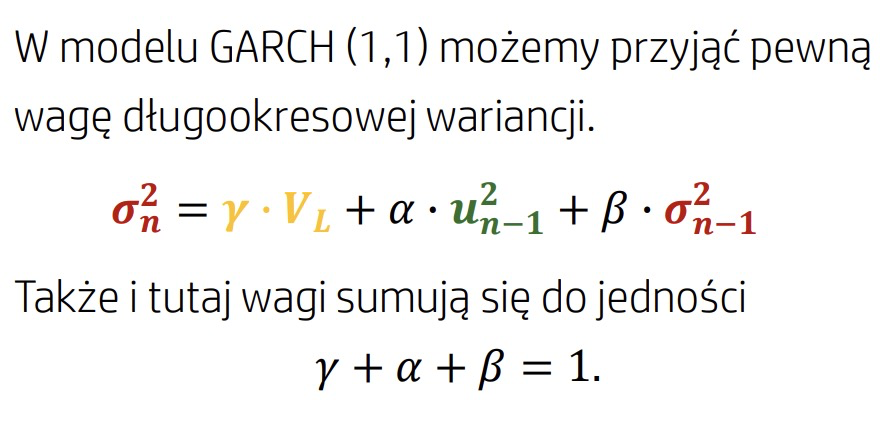
[1]

Wzór GARCH(1,1) jest w zasadzie dość podobny do EWMA pod względem struktóry, z tym, że dochodzi nam jedna nowa stała `y * Vl`

Do wyznaczenia parametrów dla wzoru użyjemy gotowej bilbioteki `arch`

In [16]:
from arch import arch_model

# GARCH najlepiej liczy się na danych przeskalowanych (np. procentach, a nie ułamkach, dlatego używamy procenty)

# używamy billioteki do dopasowania parametrów
# tworzymy model GARCH(1,1)
model = arch_model(returns_daily_log_pct_values, vol='Garch', p=1, q=1, rescale=False)
model_fit = model.fit(disp='off')

# wyliczone parametry
omega = model_fit.params['omega']
alpha = model_fit.params['alpha[1]']
beta = model_fit.params['beta[1]']

print(f"\nWyestymowane parametry GARCH(1,1):")
print(f"Omega (waga długookresowa, ma w sobie ten Y ze wzoru - Wariancję Długoterminową): {omega:.6f}")
print(f"Alpha (zwrot u^2): {alpha:.6f}")
print(f"Beta  (sigma^2): {beta:.6f}")
sum_coef = alpha + beta
print(f"Suma (Alpha + Beta): {sum_coef:.6f}") # (powinna być < 1 dla stabilności)



Wyestymowane parametry GARCH(1,1):
Omega (waga długookresowa, ma w sobie ten Y ze wzoru - Wariancję Długoterminową): 0.438161
Alpha (zwrot u^2): 0.118733
Beta  (sigma^2): 0.858356
Suma (Alpha + Beta): 0.977090


In [17]:
# Obliczamy Long Run Variance (V_L ze wzoru), przekształcamy wzór: omega / (1 - alpha - beta)
long_run_variance = omega / (1 - sum_coef)
long_run_sigma = np.sqrt(long_run_variance)

print(f"Długoterminowa wariancja (V_L): {long_run_variance:.4f}")
print(f"Długoterminowa zmienność dzienna: {long_run_sigma:.2f}%")

Długoterminowa wariancja (V_L): 19.1250
Długoterminowa zmienność dzienna: 4.37%


Z racji iż większość bibliotek podaje nam gotowe parametry omega alfa, beta, to musiałem przekształcić wyniki by wydobyć z danych nasz V_L czyli Wariancję Długoterminową.
Robię to też dlatego, bo dzięki niej możemy odpowiedzieć na pytanie jak w długim terminie zachowuje się zmienność Bitcoina.
Interpretować nasz wynik możemy w ten sposób: **Chwilowo zmienność może być 2% albo 10%, ale w bardzo długim terminie Bitcoin ma tendencję do posiadania dziennej zmienności w okolicach 4.37%.**

Mamy już parametry do modelu GARCH(1,1), więc teraz przechodzimy do dalszej części.
Obliczymy zmienność za pomocą naszego modelu, a następnie przy jej pomocy wyzanczymy znów VaR i ES.

In [18]:
# GARCH liczyliśmy na procentach, więc tutaj też operujemy na procentach
garch_sigmas_sq = np.zeros(len(returns_daily_log_pct_values))

# musimy od czegoś zacząć dlatego biorę wariancję z pierwszych 500 dni jako wartość startową
current_var = np.var(returns_daily_log_pct_values[:WINDOW])
garch_sigmas_sq[0] = current_var

# Implementacja wzoru: sigma^2 = omega + alpha * u^2 + beta * sigma^2
for i in range(1, len(returns_daily_log_pct_values)):
    # Pobieramy wartości z poprzedniego dnia (t-1)
    prev_return_sq = returns_daily_log_pct_values[i - 1] ** 2  # u_{t-1}^2
    prev_var = garch_sigmas_sq[i - 1]  # sigma_{t-1}^2

    # Obliczamy nową wariancję, nasz wzór z wykładu
    new_var = omega + alpha * prev_return_sq + beta * prev_var

    garch_sigmas_sq[i] = new_var

# Pierwiastek z wariancji daje Sigmę (Odchylenie Standardowe)
# Wynik jest w procentach (bo dane wejściowe były w %)
sigma_garch_manual = pd.Series(
    np.sqrt(garch_sigmas_sq),
    index=returns_daily_log_pct.index,
    name="Sigma GARCH (Ręczna)",
)

# Weryfikujemy nasze obliczeni z biblioteką, która ma to wbudowane
# 'arch' ma już policzoną zmienność w .conditional_volatility
# sigma_garch_lib = model_fit.conditional_volatility
sigma_garch_lib = pd.Series(
    model_fit.conditional_volatility,
    index=dates,
    name="Sigma GARCH (Biblioteka)",
)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=sigma_garch_manual.index,
        y=sigma_garch_manual,
        mode="lines",
        name="Sigma GARCH (Ręczna)",
        line=dict(color="green", width=2),
    )
)

fig.add_trace(
    go.Scatter(
        x=sigma_garch_lib.index,
        y=sigma_garch_lib,
        mode="lines",
        name="Sigma GARCH (Biblioteka)",
        line=dict(color="orange", width=1, dash="dot"),
    )
)

fig.update_layout(
    title="Weryfikacja modelu GARCH(1,1)",
    yaxis_title="Zmienność dzienna [%]",
    template="plotly_white",
)
fig.show()


Z obserwacji wykresu stwierdzam, że udało nam się wyliczyć zmienność z użyciem GARCH(1,1), wygląda on sensownie.
A co dodatkowo, oba wykresy się powielają, czyli nasza ręczna metoda działa poprawnie.
Już teraz możemy zauważyć, że wyestymowana zmienność przy użyciu GARCH(1,1) jest większa niż przy użyciu EWMA.
Przy EWMA maksymalna zmienność sięgała okolic 12% natomiast teraz widzimy, że sięga ona **okolic 17,5%**.

### VaR i ES przy pomocy GARCH(1,1) (99%, okno 500)

Kopiuję ten sam kod, który był użyty w przypadku EWMA, ponieważ algorytm jest ten sam, jedynie wyliczona zmienność się zmienia.
Nie przepisuję już kodu do osobnej funkcji, żeby nie powielać 2x tego samego kodu, ponieważ wolę się skupić na przedmiocie badania a nie idealnym programowaniu

In [19]:
sigma_garch_manual_values = sigma_garch_manual.values

# wyniki
garch_var_results = []
garch_es_results = []

# Zaczynamy od dnia WINDOW (czyli 500), bo potrzebujemy historii wstecz
for i in range(WINDOW, len(losses_daily_log_values)):
    
    # dzisiejsza zmienność (prognoza na ten dzień)
    # licznik ułamka: sigma_{n+1}
    current_sigma = sigma_garch_manual_values[i]
    
    # okno historyczne (ostatnie WINDOW dni)
    # window_losses - 'strata(i)'
    # window_sigmas - 'sigma(i)' (zmienność, która była wtedy)
    window_losses = losses_daily_log_values[i-WINDOW : i]
    window_sigmas = sigma_garch_manual_values[i-WINDOW : i]
    
    # Tworzymy WINDOW hipotetycznych scenariuszy (wzór orginalny)
    scaled_scenarios = window_losses * (current_sigma / window_sigmas)
    
    # Wyliczenie VaR (99-ty percentyl ze scenariuszy)
    var_val = np.quantile(scaled_scenarios, QUANTILE_LEVEL)
    
    # Wyliczenie ES (średnia ze scenariuszy gorszych niż VaR)
    es_val = scaled_scenarios[scaled_scenarios >= var_val].mean()
    
    garch_var_results.append(var_val)
    garch_es_results.append(es_val)

# Indeks musi zaczynać się od daty WINDOW, bo wcześniej nie mamy wyników
results_index = dates[WINDOW:]

garch_var_series = pd.Series(garch_var_results, index=results_index, name="VaR 99% (GARCH)")
garch_es_series = pd.Series(garch_es_results, index=results_index, name="ES 99% (GARCH)")

print("Ostatnie 5 wyników VaR:")
print(garch_var_series.tail())

Ostatnie 5 wyników VaR:
datetime
2025-11-17    0.064401
2025-11-18    0.063747
2025-11-19    0.061197
2025-11-20    0.059754
2025-11-21    0.071331
Name: VaR 99% (GARCH), dtype: float64


In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=results_index,
    y=losses_daily_log_values[WINDOW:] * 100,
    mode='lines',
    name='Rzeczywista Strata (Log)',
    line=dict(color='silver', width=1),
    opacity=0.4
))

# VaR
fig.add_trace(go.Scatter(
    x=garch_var_series.index,
    y=garch_var_series * 100,
    mode='lines',
    name='VaR 99% (GARCH)',
    line=dict(color='red', width=1.5)
))

# ES
fig.add_trace(go.Scatter(
    x=garch_es_series.index,
    y=garch_es_series * 100,
    mode='lines',
    name='ES 99% (GARCH)',
    line=dict(color='black', width=1.5, dash='dot')
))

fig.update_layout(
    title=f"VaR i ES metodą historyczną ze skalowaniem zmiennością (GARCH)",
    xaxis_title="Data",
    yaxis_title="Strata [%]",
    template="plotly_white",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Tak jak wcześniej zaobserwowaliśmy, tak też tu to się potwierdza. Model GARCH podchodzi bardziej rygorystycznie do estymowania zmienności a co przez to idzie VaR i ES.

**Pisząć regorystycznie mam na myśli zapas jaki zostawia w przypadku wybranego progu 99%**.
Widzimy, iż dla "covidowego crashu" mamy oszacowanie **VaR na poziomie ~56% oraz ES na poziomie ~107,5%**. Są to znaczne wartości, ale to jest właśnie ten dzień w którym nasza strata 99% została osiągniętą ze sporą nawiązką.

Z obserwacji, mam także wrażenie iż VaR i ES jest bardziej stonowane dla ostatmnich 2 lat w porównaniu do VaR i ES wyliczonego przy użyciu EWMA.
By to sprawdzić, nałożę ona wykresy na siebie by je porównać

In [21]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=results_index,
    y=losses_daily_log_values[WINDOW:] * 100,
    mode='lines',
    name='Rzeczywista Strata',
    line=dict(color='silver', width=1),
    opacity=0.5
))

# METODA EWMA
# VaR
fig.add_trace(go.Scatter(
    x=ewma_var_series.index,
    y=ewma_var_series * 100,
    mode='lines',
    name='VaR 99% (EWMA)',
    line=dict(color='red', width=1.5)
))

# ES
fig.add_trace(go.Scatter(
    x=ewma_es_series.index,
    y=ewma_es_series * 100,
    mode='lines',
    name='ES 99% (EWMA)',
    line=dict(color='darkred', width=1.5, dash='dot'),
))

# METODA GARCH
# VaR
fig.add_trace(go.Scatter(
    x=garch_var_series.index,
    y=garch_var_series * 100,
    mode='lines',
    name='VaR 99% (GARCH)',
    line=dict(color='green', width=1.5)
))

# ES
fig.add_trace(go.Scatter(
    x=garch_es_series.index,
    y=garch_es_series * 100,
    mode='lines',
    name='ES 99% (GARCH)',
    line=dict(color='darkgreen', width=1.5, dash='dot')
))

fig.update_layout(
    title="PORÓWNANIE: Metoda Historyczna ze skalowaniem (EWMA vs GARCH)",
    xaxis_title="Data",
    yaxis_title="Strata [%]",
    template="plotly_white",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Porównując wyestymowane VaR i ES z obu metod, widzę następujące dwa wnioski:

- GARCH nie tylko **agresywniej reaguje na wzrost zmienności, ale także na jej spadek**. Czyli **szybciej zapomina przeszłą zmienność**.
- Przyglądając się latom 2024-2025 widzę, iż **moje rozważania dotyczące tego, że GARCH jest bardziej stonowany, są błedne**. Z bliska widzę, że reaguje on dobrze na nagły wzrost zmienności, tak samo dobrze jak EWAM. Jedna różni ich szacowanie dalszej zmienności po takich "wybiciach" nagłych. GARCH dość szybko dostosowuję się do zmniejszonej zmiennośći.

Prawodpodbnie dla banków i insttytucji, jeśli by im zależało na tym by móc ulokować jak najmniej kapitały w zapasowych rezerwach, moddel GARCH spełni się lepiej ponieważ pozwoli im na szybsze uwolnienie kapitału. Ocenę czy to dobrze, czy nie pozostawiam do własnego wniosku.

## Testy Wsteczne (backtesting)

testy wsteczne wykonam wykorzystując:

#### Test Kupca
H0: VaR jest **dobrze wyznaczony**
H1: VaR **nie jest dobrze wyznaczony**

Dla naszego 99% i 250 dni, ilość wyjątków powinna mieścić się w zakresie [0, 7]

Ten test pozwala sprawdzić czy ogólna ilość wyjątków pasuje do naszego przyjętego percentyla VaR

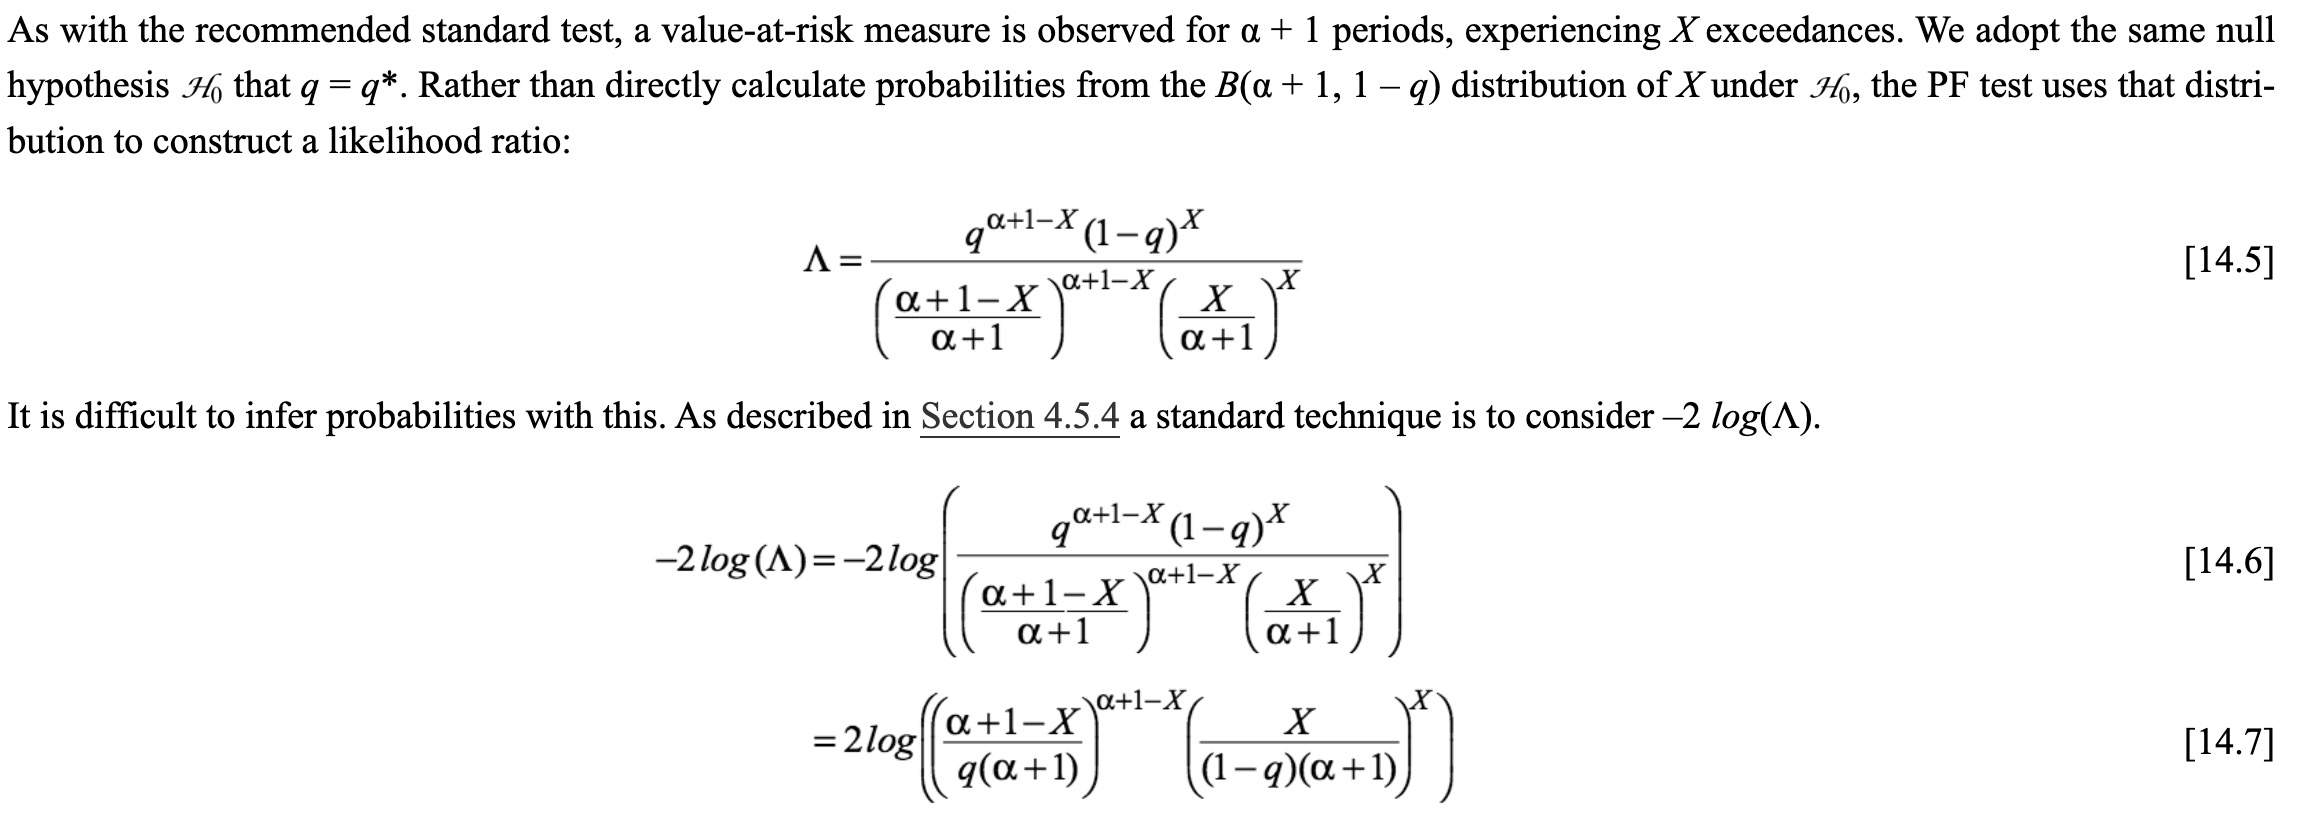
[2]

#### Test Christoffersona
H0: przekroczenia VaR są **niezależne w czasie**
H1: przekroczenia VaR **nie są niezależne w czasie**

Tym testem badamy czy jeśli nasze wyjątki występuja to czy są one niezależne w czasie. Prosto mówiąc czy nasze wyjątki są skupione w pojedynczych miejscach, czy jedak są rozłożone w miarę równomiernie na naszej osi czasu

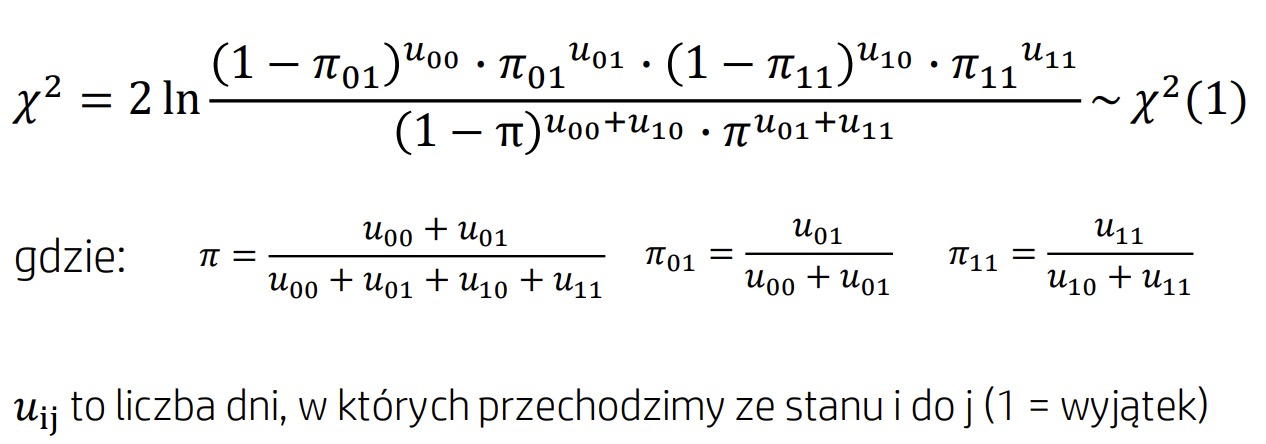
[1]

#### Test Świateł (komitet Bazylejski)
Reguła nie polega na teście potwierdzającym / odrzucającym tezę, tylko na zakresach iloścy wystąpień

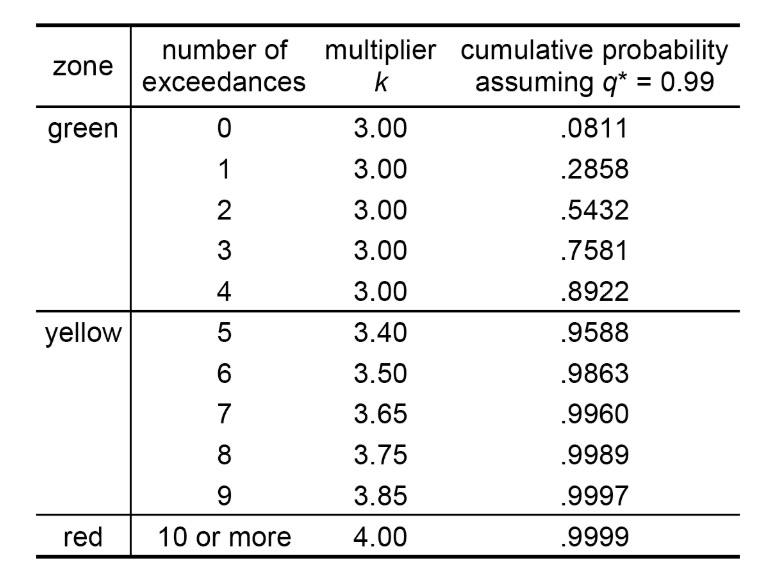
[2]

W uproszczeniu możnapowiedzieć, że w zależności od liczny wystąpień na zakresie 250 dni i przy użyciu VaR 99%:
- **0-4**: Zielone Światło (VaR dobrze wynaczony)
- **5-9**: Pomarańczowe Światło (Należy sprawdzić swój wyzanczany VaR i go skorygować)
- **>9**: Czerwone Światło (VaR nie jest dobrze wynaczony)


Najpierw poglądowo sprawdzę ile wyjątków występuje dla każdej z metod na całym okresie badania

In [22]:
# przygotowanie danych do testów
real_losses_pct_from_window = losses_daily_log_pct[WINDOW:]

# ułamki na procenty
ewma_var_series_pct = ewma_var_series * 100
garch_var_series_pct = garch_var_series * 100


# funkcje pomocnicze do przeprowadzenia testów
def compute_details(actual, forecast, confidence=0.99):
    idx = actual.index.intersection(forecast.index)
    actual, forecast = actual.loc[idx], forecast.loc[idx]
    
    N = len(actual)
    hits = (actual > forecast).sum() # Liczba przekroczeń
    rate = hits / N
    expected_rate = 1 - confidence
        
    return hits, N*expected_rate, rate

print(f"Wyniki backtesttingu (VaR 99%, Próba: {len(real_losses_pct_from_window)} dni)\n")

# EWMA
h_e, exp_e, r_e = compute_details(real_losses_pct_from_window, ewma_var_series_pct)
print(f"EWMA:  wyjątków: {h_e} (Oczekiwano: {exp_e:.1f}) | Procent wyjątków: {r_e*100:.2f}%")

# GARCH
h_g, exp_g, r_g = compute_details(real_losses_pct_from_window, garch_var_series_pct)
print(f"GARCH: wyjątków: {h_g} (Oczekiwano: {exp_g:.1f}) | Procent wyjątków: {r_g*100:.2f}%")

fig = go.Figure()

# straty
fig.add_trace(go.Scatter(
    x=real_losses_pct_from_window.index, y=real_losses_pct_from_window, 
    name='Rzeczywista Strata', line=dict(color='silver', width=1), opacity=0.5
))

# EWMA (Czerwony)
fig.add_trace(go.Scatter(
    x=ewma_var_series_pct.index, y=ewma_var_series_pct, 
    name='VaR EWMA', line=dict(color='red', width=1.5)
))

# wyjątki EWMA (Czerwone kółka)
hits_ewma = real_losses_pct_from_window[real_losses_pct_from_window > ewma_var_series_pct]
fig.add_trace(go.Scatter(
    x=hits_ewma.index, y=hits_ewma, 
    mode='markers', name='Wyjątki EWMA',
    marker=dict(color='red', symbol='circle-open', size=9, line=dict(width=2))
))

# GARCH (Zielony)
fig.add_trace(go.Scatter(
    x=garch_var_series_pct.index, y=garch_var_series_pct, 
    name='VaR GARCH', line=dict(color='green', width=1.5)
))

# wyjątki GARCH (Zielone krzyżyki)
hits_garch = real_losses_pct_from_window[real_losses_pct_from_window > garch_var_series_pct]
fig.add_trace(go.Scatter(
    x=hits_garch.index, y=hits_garch, 
    mode='markers', name='Wyjątki GARCH',
    marker=dict(color='green', symbol='x', size=7)
))

fig.update_layout(
    title="Backtesting: Przekroczenia VaR (Porównanie EWMA vs GARCH)",
    yaxis_title="Strata [%]",
    template="plotly_white",
    hovermode="x unified"
)
fig.show()

Wyniki backtesttingu (VaR 99%, Próba: 3477 dni)

EWMA:  wyjątków: 41 (Oczekiwano: 34.8) | Procent wyjątków: 1.18%
GARCH: wyjątków: 42 (Oczekiwano: 34.8) | Procent wyjątków: 1.21%


Jak możemy zauważyć, wyznaczony przez nas **VaR** za pomocą obu metod **jest odrobinę zbyt mało rygorystyczny** (jednak w moim odczuciu nie jest to na tyle duża rożnica by móc powiedzieć, że VaR jest źle wyliczony. Trzeba wziąść pod uwagę, że **na rynku występują nieprzewidywane momenty** jak wspominany już wiele razy "crash covidowy", czy nałożenie taryf przez prezydenta Donalda Trumpa).

W przypadku EWMA jest on minimalnie lepszy i różni się jedynie o 0.18 punkta procentowego od oczekiwanego 1% wyjątków, natomiast GARCH o 0.21 (czyli między nimi roóznica to tylko 0.03%. Prawie nic jeśli weźmiemy pod uwagę, że zakres badania to 10 lat).

Na wykresie możemy też ręcznie sprawdzić dokładnie miejsca wyjątków.

**Na pierwszy rzut oka, wydaje się, że są one równomiernie rozłożone, co sugerowało by, że test Christoffersona powie nam iż wyjątki są niezależne w czasie.**

Aby się przekonać czy nasze spostrzeżenie jest prawidłowe, przechodzimy teraz do naszych testów.

In [23]:
# funkcje pomocnicze do testów Kupca i Christoffersona zaimplementowane na podstawie wzorów z wykładów oraz poleconych materiałów
def get_kupiec_pvalue(hits_window, confidence=0.99):
    """
    oblicza p-value testu Kupca używając wzoru z książki Glyn A. Holton.
    LR = 2 * [ (N-x)*ln((N-x)/(N*q)) + x*ln(x/(N*(1-q))) ]
    """
    hits = np.array(hits_window)
    N = len(hits)                 # odpowiada (alpha + 1) ze wzoru (zakres obserwacji)
    x = np.sum(hits)              # odpowiada X ze wzoru
    q = confidence              # odpowiada q ze wzoru (0.99)
    
    # obsługa przypadków skrajnych (gdy x=0 lub x=N logarytm jest nieprawidłowy)
    # liczymy granicę wzoru w tych punktach. Skrócona wersja
    if x == 0:
        # gdy x=0, drugi człon znika, zostaje pierwszy: 2 * N * ln(1/q)
        lr_stat = -2 * N * np.log(q)
    elif x == N:
        # gdy x=N, pierwszy człon znika, zostaje drugi: 2 * N * ln(1/(1-q))
        lr_stat = -2 * N * np.log(1 - q)
    else:
        # normalny przypadek
        # człon 1: (N-x) * ln( (N-x) / (N*q) )
        term1 = (N - x) * np.log((N - x) / (N * q))
        
        # człon 2: x * ln( x / (N*(1-q)) )
        term2 = x * np.log(x / (N * (1 - q)))
        
        lr_stat = 2 * (term1 + term2)
    
    # p-value z rozkładu Chi-kwadrat (1 stopień swobody)
    p_value = 1 - stats.chi2.cdf(max(0, lr_stat), 1)
    
    return p_value

def get_christofferson_pvalue(hits_window):
    """
    oblicza p-value testu Christoffersona ze wzoru z wykładów.
    """
    hits = np.array(hits_window)
    
    # Potrzebujemy co najmniej 2 wyjątków, żeby badać ich grupowanie. Jeśli ich nie ma to zwracamy 1.0
    if np.sum(hits) < 2:
        return 1.0 
        
    # pary (wczoraj -> dzisiaj)
    curr = hits[1:]
    prev = hits[:-1]
    
    # liczymy przejścia (n00, n01, n10, n11)
    n00 = ((prev==0) & (curr==0)).sum()
    n01 = ((prev==0) & (curr==1)).sum()
    n10 = ((prev==1) & (curr==0)).sum()
    n11 = ((prev==1) & (curr==1)).sum()
    
    # prawdopodobieństwa przejść (pi_01, pi_11)
    # pi_01: prawdopodobieństwo wyjątku, gdy wczoraj nie było wyjątku
    # pi_11: prawdopodobieństwo wyjątku, gdy wczoraj był też wyjątek
    
    # zabezpieczenie przed dzieleniem przez zero
    if (n00 + n01) == 0 or (n10 + n11) == 0:
        return 1.0
        
    pi_01 = n01 / (n00 + n01)
    pi_11 = n11 / (n10 + n11)
    pi_all = (n01 + n11) / (n00 + n01 + n10 + n11) # ogólne prawdopodobieństwo błędu
    
    # jeśli prawdopodobieństwa są zerowe lub jedynkowe, logarytmy będą nieprawidłowe, więc upraszczamy
    if pi_01 == 0 and pi_11 == 0: return 1.0
    if pi_all == 0 or pi_all == 1: return 1.0

    # obliczamy Log-Likelihood (Dla H0 i H1)
    # H0: błędy są niezależne (pi_01 = pi_11 = pi_all)
    ln_null = (n00+n10)*np.log(1-pi_all) + (n01+n11)*np.log(pi_all)
    
    # H1: błędy zależą od siebie (pi_01 != pi_11)
    # musimy uważać też na log(0), dlateog pomocnicza funkcja
    def safe_log(val): return np.log(val) if val > 0 else 0
    
    ln_alt = (n00 * safe_log(1-pi_01)) + (n01 * safe_log(pi_01)) + \
             (n10 * safe_log(1-pi_11)) + (n11 * safe_log(pi_11))
             
    lr_stat = -2 * (ln_null - ln_alt)
    
    # p-value z rozkładu Chi-kwadrat (1 stopień swobody)
    p_value = 1 - stats.chi2.cdf(max(0, lr_stat), 1)
    
    return p_value

In [24]:
hits_ewma = (real_losses_pct_from_window > ewma_var_series_pct).astype(int)
hits_garch = (real_losses_pct_from_window > garch_var_series_pct).astype(int)

results = {
    'Date': [],
    'EWMA_Kupiec': [], 'EWMA_Christofferson': [],
    'GARCH_Kupiec': [], 'GARCH_Christofferson': []
}

# Iterujemy od 250-go dnia do końca
TEST_WINDOW = 250

for i in range(TEST_WINDOW, len(real_losses_pct_from_window)):
    
    # Wycinamy okno (ostatnie 250 dni od dnia 'i')
    w_ewma = hits_ewma[i-TEST_WINDOW : i]
    w_garch = hits_garch[i-TEST_WINDOW : i]
    
    results['Date'].append(dates[i])
    
    # EWMA
    results['EWMA_Kupiec'].append(get_kupiec_pvalue(w_ewma))
    results['EWMA_Christofferson'].append(get_christofferson_pvalue(w_ewma))
    
    # GARCH
    results['GARCH_Kupiec'].append(get_kupiec_pvalue(w_garch))
    results['GARCH_Christofferson'].append(get_christofferson_pvalue(w_garch))

df_results = pd.DataFrame(results).set_index('Date')

In [25]:
# suma krocząca 250 dni (dla świateł bazylejskich)
rolling_hits_ewma = hits_ewma.rolling(window=TEST_WINDOW).sum()
rolling_hits_garch = hits_garch.rolling(window=TEST_WINDOW).sum()

fig1 = go.Figure()

# Linia krytyczna dla p-value 0.05
fig1.add_hline(y=0.05, line_dash="dash", line_color="black", annotation_text="Limit odrzucenia dla p-value (0.05)")

# EWMA (Czerwone)
fig1.add_trace(go.Scatter(
    x=df_results.index, y=df_results['EWMA_Kupiec'],
    name='EWMA: Kupiec (Ilość)',
    line=dict(color='red', width=1.5)
))
fig1.add_trace(go.Scatter(
    x=df_results.index, y=df_results['EWMA_Christofferson'],
    name='EWMA: Christofferson (Klastry)',
    line=dict(color='darkred', width=1.5, dash='dot')
))

# GARCH (Zielone)
fig1.add_trace(go.Scatter(
    x=df_results.index, y=df_results['GARCH_Kupiec'],
    name='GARCH: Kupiec (Ilość)',
    line=dict(color='green', width=1.5)
))
fig1.add_trace(go.Scatter(
    x=df_results.index, y=df_results['GARCH_Christofferson'],
    name='GARCH: Christofferson (Klastry)',
    line=dict(color='darkgreen', width=1.5, dash='dot')
))

fig1.update_layout(
    title="1. Backtesting Statystyczny: P-value testów (okno 250 dni)",
    yaxis_title="P-value (Im wyżej tym lepiej)",
    xaxis_title="Data",
    template="plotly_white",
    hovermode="x unified",
    yaxis=dict(range=[0, 1.05])
)

fig1.show()

fig2 = go.Figure()

# strefy
# zielona (0-4)
fig2.add_hrect(
    y0=0, y1=4, fillcolor="green", opacity=0.1, line_width=0, 
    annotation_text="Strefa Zielona (OK)", annotation_position="top left"
)
# żółta (5-9)
fig2.add_hrect(
    y0=4, y1=9, fillcolor="yellow", opacity=0.15, line_width=0, 
    annotation_text="Strefa Żółta (Uwaga)", annotation_position="top left"
)
# czerwona (10+)
fig2.add_hrect(
    y0=9, y1=40, fillcolor="red", opacity=0.1, line_width=0, 
    annotation_text="Strefa Czerwona (Odrzucenie)", annotation_position="top left"
)

# modele
fig2.add_trace(go.Scatter(
    x=rolling_hits_ewma.index, y=rolling_hits_ewma,
    mode='lines', name='EWMA (Suma przekroczeń)',
    line=dict(color='red', width=2)
))

fig2.add_trace(go.Scatter(
    x=rolling_hits_garch.index, y=rolling_hits_garch,
    mode='lines', name='GARCH (Suma przekroczeń)',
    line=dict(color='green', width=2)
))

fig2.update_layout(
    title="2. Backtesting Regulacyjny: Test Świateł (okno 250 dni)",
    xaxis_title="Data",
    yaxis_title="Liczba przekroczeń (ostatnie 250 dni)",
    template="plotly_white",
    hovermode="x unified",
    yaxis=dict(range=[0, 12], dtick=1) 
)

fig2.show()

### Interpretacja wyników testów

Przeglądając cały zakres badania testami, w oczy rzuca mi się moment sierpnia 2023 roku.
Wydawało mi się to błedne, iż **testy świateł oraz Christoffersona** wskazywały nam, że VaR jest poprawnie, natomiast **test Kupca** mówił odwrotnie.
Po głebszej analizie i eksploracji okazało się, że moja metoda jest poprawna. To, że **według tabeli testu Kupca** poprawna ilość wyjątków to `[0, 7]` wynika z tego, że **aproksymacja rozkładem chi^2 na której bazuje wzór Kupca, wykazuje znaczące rozbieżności** ("meaningful discrepancies") przy małej liczbie zdarzeń, czyli u nas 2,5. Jest to zazanczone w książce Holtona:

> Kupiec found this approximation to be reasonable based on a Monte Carlo analysis, but Lopez (1999) claims to have found “meaningful” discrepancies using his own Monte Carlo analysis [2].

Dlatego poziom odrzucenia został potem podany w zakresach, gdzie dla naszej konfiguracji jest to wspomniany zakres `[0, 7]`.

Dlatego ten momentu odrzucania testu Kupca w sierpniu 2023 roku możemy uznać za nieprawidłowy (oraz tak samo grudzień 2018 rok, gdzie też trafiamy na graniczną wartość 7). W związku z tym uwzględniając te uwagi i ilość wyjatków, możemy śmiało przyjąć, że test Kupca na oknie 250 dni cofając si wstecz, mówi nam iż nasz VaR jest prawidłowo wyznaczony.

Przechodząc do analizy **testu Christoffersona** widzimy, że tutaj mamy jeden dłuższy momemnt, I i II kwartał 2023 roku, gdy wskazuje on nam, że wyjątki nie są niezależne w czasie.
By to zweryfikować realnie patrząc na wyjątki, cofamy się do wcześniejszych wykresów gdzie zazanczyliśmy je na osi czasu oraz sprawdzimy wykres OHLC dla Bitcona.

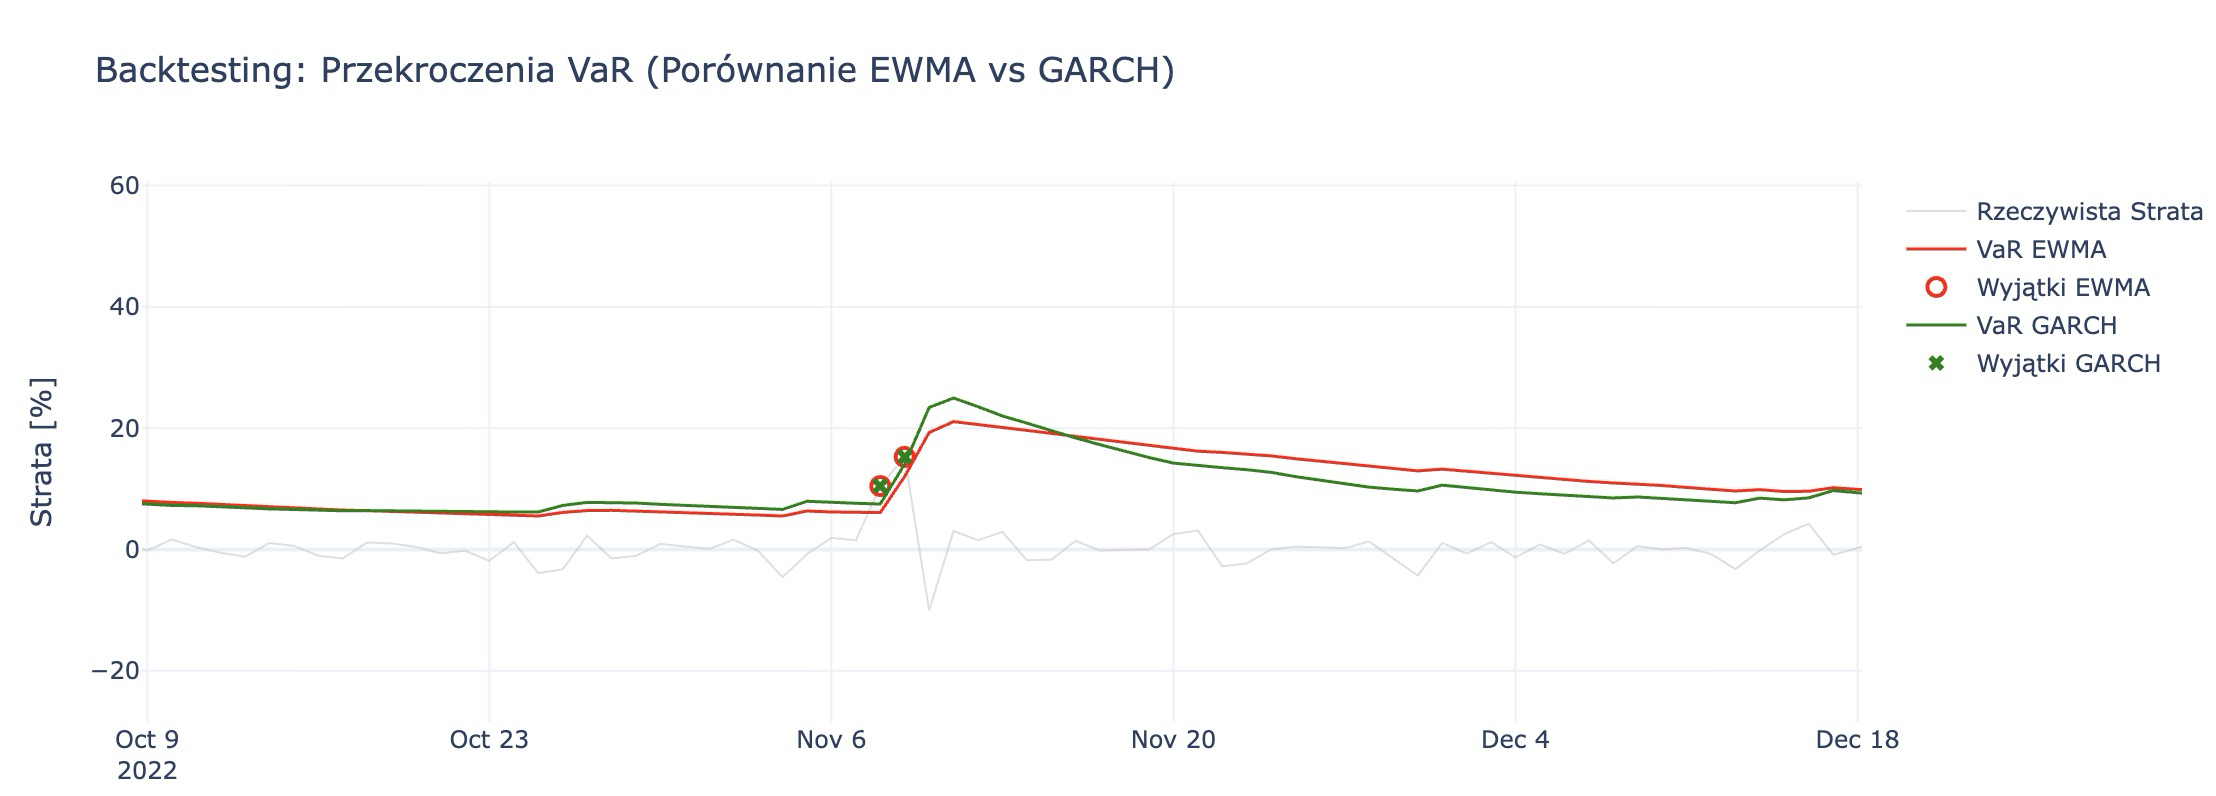

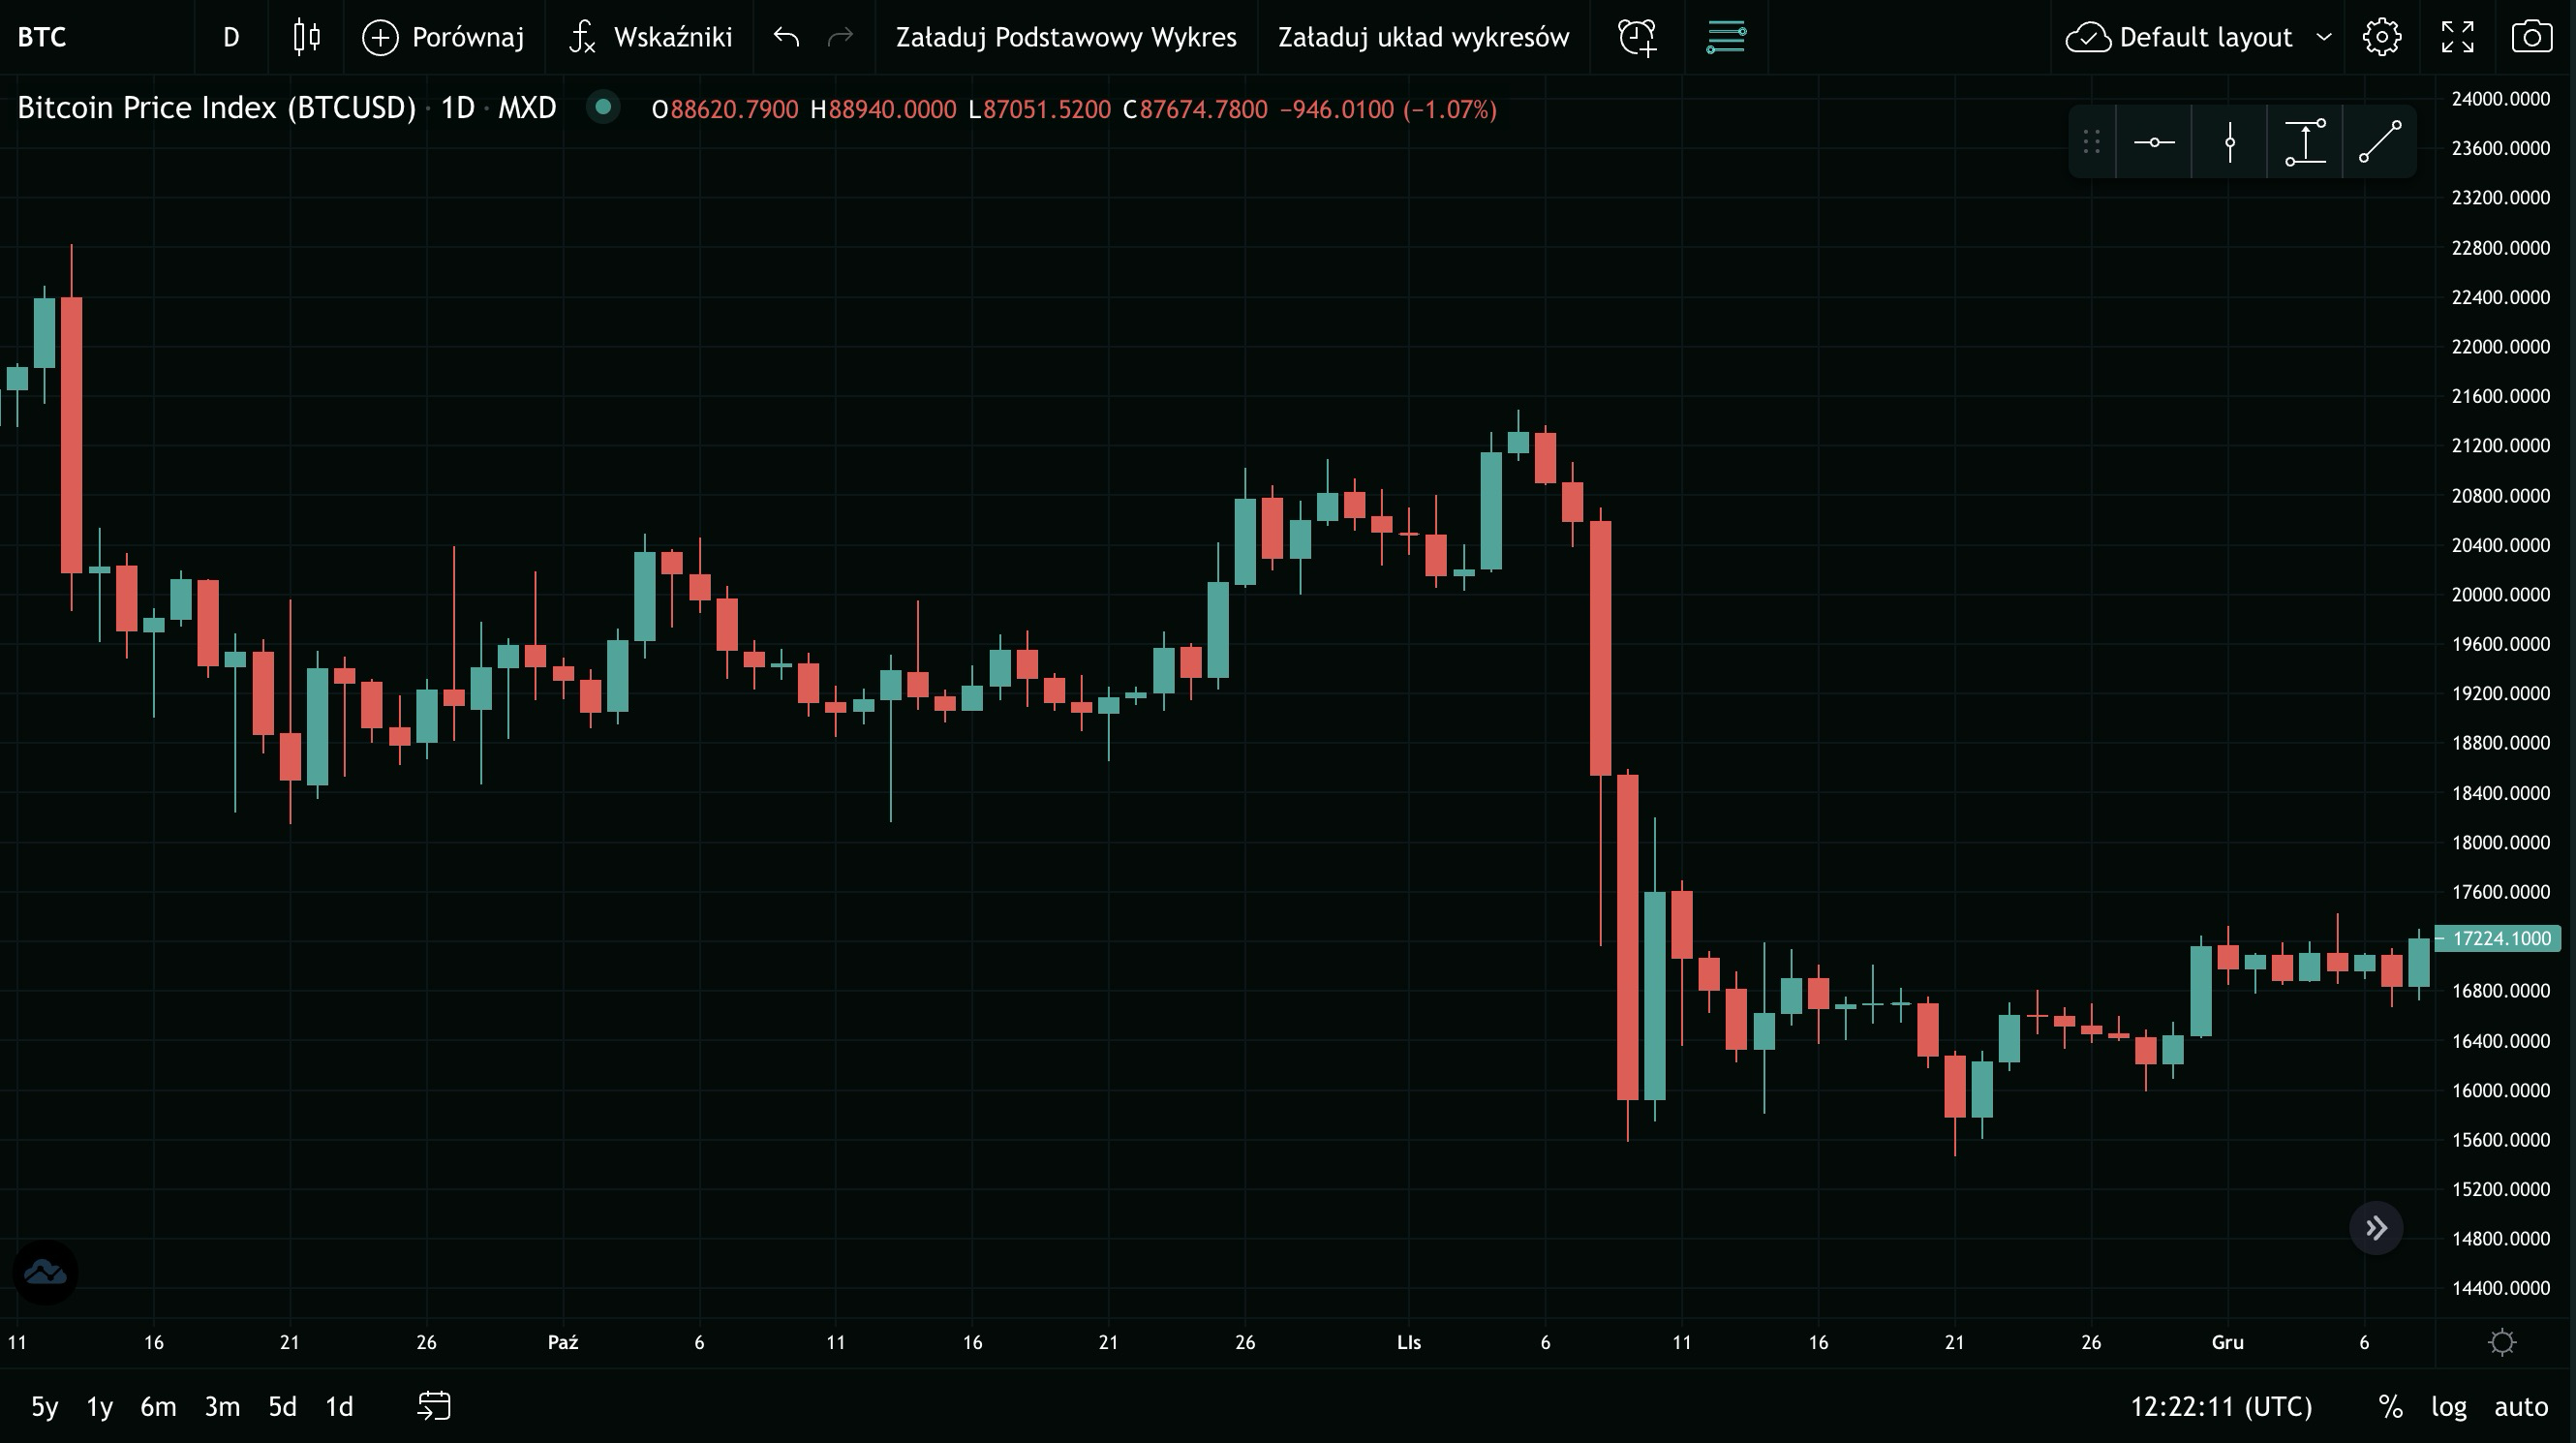

Analizując oba wykresy widzimy jasno, że 8 i 9 listopada 2022 roku nastąpiły dwa dni mocnych spadków (~17% i 16%), które przekraczały dzień po dniu nasz wyznaczony VaR. Dlatego też test Christoffersona prawidłowo mówi nam, że VaR nie był prawidłowo wyznaczony, gdyż mieliśmy zależne wyjątki w czasie.
Realnie do tego podchodząc, sądzę, że nie da się przeiwdzieć takich sytuacji na rynku, który jest podatny na wpływ informacji oraz bardzo zmienny.

Kończą **testem Świateł**, widzimy, że jest on najłatwiejszy do analizy. Jasno widzimy z jego wykresu, że obie metody wyznaczające VaR są poprawne i tylko momentami zaczynają wchodzić do pomarańczowej strefy. Nie oznacza to, że są one niepoprawne, tylko że należy się przyjrzeć naszej metodzie wyznaczania VaR. Tak jak wyżej wspominałem, myślę, że należało się tego spodziewać po Bitcoinie.

## Podsumowanie

Analizując nasze całe badanie i przeprowdzone testy, **uważam, że obie metody prawidłowo wyznaczają VaR dla Bitcoina**.
Ich rezultat jest bardzo podobny, więc **nie ma tu lepszej i gorszej metody**. Działają one na całym zakresie podobnie.
Myślę, że może być to spowodowane tym, że zmiennośc na Bitcoinie jest dość duża, więc przewidywania zmienności a co z tym idzie VaR mogą mieć większy margines błedu.
Podejrzewam, że wraz z upływam lat im bardziej aktywo jakim jest Bitcoin będzie się stabilizować, tym większa jest szansa, by zaobserwować jakieś mocniejsze różnice między wyzanczaniem zmienności za pomocą EWMA i GARCH(1,1) oraz wyznaczanego za ich pomocą VaR.

[1] - dr. Wolak J. (2025). Ilościowe miary ryzyka rynkowego. AGH, Wydział Zarządzania.

[2] - Glyn A. Holton (2013). Value-at-Risk: Theory and Practice (Second Edition).